In [115]:
%load_ext autoreload
%autoreload

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Reshape,Flatten,UpSampling2D,concatenate, Activation

import numpy as np
import matplotlib.pyplot as plt

from constants import INPUT_SHAPE
from conversion import read_room2class, get_class2color, FloorplanRaw, FloorplanSVG, read_room2class_condensed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Mappings for dataset
room2class = read_room2class_condensed("room_types_succinct.txt")
class2room = {v: k for k, v in room2class.items()}
class2color = get_class2color(max(room2class.values())+1)

n_classes = max(room2class.values())+1

# Semantic Segmentation Model

In [11]:
# Build model

# model = Sequential()

# n_filters = 64
# # Add network layers
# model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same', input_shape=INPUT_SHAPE))
# model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(n_filters*2, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(n_filters*2, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))


# model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same'))
# model.add(Conv2DTranspose(32,(5,5),padding='same', activation=tf.nn.leaky_relu, strides=(2, 2)))
# model.add(Conv2DTranspose(16,(5,5),padding='same', activation=tf.nn.leaky_relu, strides=(2, 2)))
# model.add(Conv2DTranspose(n_classes,(5,5),padding='same', activation=tf.nn.softmax))


# # compile model
# opt = Adam(lr=0.001)
# loss = tf.keras.losses.categorical_crossentropy
# model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

# model.summary()


# Simple model for testing
# model = Sequential()
# model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=INPUT_SHAPE))

# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# model.add(Conv2DTranspose(64, (3, 3), padding='same', activation='relu', strides=(2, 2)))
# model.add(Conv2DTranspose(64, (3, 3), padding='same', activation='relu', strides=(2, 2)))
# model.add(Dropout(0.5))
# model.add(Conv2DTranspose(64, (3, 3), padding='same', activation='relu', strides=(2, 2)))
# model.add(Conv2D(n_classes, (3, 3), padding='same', activation=tf.nn.softmax))

# opt = Adam(lr=0.001)
# loss = tf.keras.losses.categorical_crossentropy
# model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

# model.summary()

In [12]:
input_layer = Input(shape=INPUT_SHAPE)

#encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

#decoder
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='linear', padding='same')(conv5)


out = Conv2D(n_classes, (1, 1) , padding='same', activation=tf.nn.softmax)(conv5)


model = Model(input_layer ,out, name = 'U-net')

loss = tf.keras.losses.categorical_crossentropy
opt = Adam(lr = 0.001)
model.compile(loss= loss, optimizer=opt, metrics = ['accuracy'])
model.summary()

Model: "U-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 256, 256, 32) 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 32) 9248        dropout_5[0][0]                  
______________________________________________________________________________________________

# Train

In [106]:
dataset_dir = "./data/cubicasa5k"
batch_size = 32

def plot_training_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1,len(accuracy)+1)

    plt.figure()
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
def plot_training_history_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

## Train by Generator

In [ ]:
# Build data generators

# def generator(dataset_dir, txt_name, room2class, batch_size, mode="train"):
#     """Generator for training data
#     """
#     dataset_txt = dataset_dir + txt_name
#     f = open(dataset_txt, "r")
#     while True:
#         inputs = []
#         labels = []
#         while len(inputs) < batch_size:
            
#             # Read next line, back from beginning if reaching end
#             line = f.readline().strip()
#             if not line:
#                 f.seek(0)
#                 line = f.readline().strip()
                
#                 #TODO: if mode is eval, do not seek to 0
            
#             # Get our converted data
#             data_folder = dataset_dir + line
#             raw = FloorplanRaw(data_folder)
#             svg = FloorplanSVG(data_folder, raw.original_shape, room2class)
            
#             inputs.append(raw.image)
#             labels.append(svg.semantic_map)
        
#         inputs = np.array(inputs)
#         labels = to_categorical(np.array(labels), num_classes=n_classes)
#         yield inputs, labels


# train_gen = generator(dataset_dir, "/train.txt", room2class, batch_size)
# val_gen = generator(dataset_dir, "/val.txt", room2class, batch_size)


def generator_from_processed(dataset_dir, txt_name, batch_size, mode="train"):
    """Generator for training data
    """
    dataset_txt = dataset_dir + txt_name
    f = open(dataset_txt, "r")
    while True:
        inputs = []
        labels = []
        while len(inputs) < batch_size:
            
            # Read next line, back from beginning if reaching end
            line = f.readline().strip()
            if not line:
                f.seek(0)
                line = f.readline().strip()
                
                #TODO: if mode is eval, do not seek to 0
            
            # Get our converted data
            data_folder = dataset_dir + line
            input_data = np.load(data_folder+"input.npy")
            label_data = np.load(data_folder+"label.npy")
            
            inputs.append(input_data)
            labels.append(label_data)
        
        inputs = np.array(inputs)
        labels = to_categorical(np.array(labels), num_classes=n_classes)
        yield inputs, labels
        

train_dir = dataset_dir + "/train"
train_gen = generator_from_processed(train_dir, "/train.txt", batch_size)

val_dir = dataset_dir + "/val"
val_gen = generator_from_processed(val_dir, "/val.txt", batch_size)

In [ ]:
%%time
# Train
num_train_images = len(open(dataset_dir + "/train/train.txt", "r").readlines())
steps_per_epoch = num_train_images // batch_size // 60
num_val_images = len(open(dataset_dir + "/val/val.txt", "r").readlines())
validation_steps = num_val_images // batch_size // 2
num_epochs = 1
verbose = 1

history = model.fit_generator(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_gen,
                    validation_steps=validation_steps,
                    epochs=num_epochs,
                    verbose=verbose)

In [ ]:
for i in range(validation_steps):
    print(i)
    a, b = next(val_gen)

In [ ]:
b.shape

In [ ]:
plt.figure(figsize = (10, 10))
plt.imshow(a[0])
result = np.argmax(b[0], axis=-1)
FloorplanSVG.show_map(result, a[0], class2color, class2room)

In [ ]:
# Plot history
plot_training_history(history)

In [ ]:
FloorplanSVG(trial_folder, raw.original_shape, room2class).show(0*np.ones_like(input_img), class2color, class2room)

## Train by Numpy Array

In [14]:
# Load data
train_X = np.load(dataset_dir + "/train_inputs.npy")
train_y = np.load(dataset_dir + "/train_labels.npy")
train_y = to_categorical(train_y, num_classes=n_classes, dtype=np.int8)

In [15]:
val_X = np.load(dataset_dir + "/val_inputs.npy")
val_y = np.load(dataset_dir + "/val_labels.npy")
val_y = to_categorical(val_y, num_classes=n_classes, dtype=np.int8)

In [92]:
%%time
# Train
num_train_images = len(open(dataset_dir + "/train.txt", "r").readlines())
steps_per_epoch = num_train_images // batch_size
num_val_images = len(open(dataset_dir + "/val.txt", "r").readlines())
validation_steps = num_val_images // batch_size
num_epochs = 50
verbose = 1

history = model.fit(train_X,
                    train_y,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=verbose,
                    validation_data=(val_X, val_y),
                    shuffle=False)

Train on 825 samples, validate on 104 samples
Epoch 1/50
825/825 [==============================] - 319s 387ms/sample - loss: 1.4590 - accuracy: 0.5065 - val_loss: 1.4477 - val_accuracy: 0.4870
Epoch 2/50
825/825 [==============================] - 322s 391ms/sample - loss: 1.4112 - accuracy: 0.5066 - val_loss: 1.4141 - val_accuracy: 0.4871
Epoch 3/50
825/825 [==============================] - 317s 384ms/sample - loss: 1.3816 - accuracy: 0.5072 - val_loss: 1.3907 - val_accuracy: 0.4872
Epoch 4/50
825/825 [==============================] - 317s 384ms/sample - loss: 1.3668 - accuracy: 0.5109 - val_loss: 1.3666 - val_accuracy: 0.4935
Epoch 5/50
825/825 [==============================] - 317s 384ms/sample - loss: 1.3285 - accuracy: 0.5219 - val_loss: 1.3461 - val_accuracy: 0.4984
Epoch 6/50
825/825 [==============================] - 318s 385ms/sample - loss: 1.3065 - accuracy: 0.5256 - val_loss: 1.3279 - val_accuracy: 0.5005
Epoch 7/50
825/825 [==============================] - 317s 385ms/s

In [108]:
%%time
# Train for more epochs
num_epochs = 4

history = model.fit(train_X,
                    train_y,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=verbose,
                    validation_data=(val_X, val_y),
                    shuffle=False)

Train on 825 samples, validate on 104 samples
Epoch 1/4
825/825 [==============================] - 318s 385ms/sample - loss: 1.0070 - accuracy: 0.6289 - val_loss: 1.0133 - val_accuracy: 0.6241
Epoch 2/4
825/825 [==============================] - 316s 383ms/sample - loss: 0.9903 - accuracy: 0.6351 - val_loss: 1.0182 - val_accuracy: 0.6252
Epoch 3/4
825/825 [==============================] - 320s 388ms/sample - loss: 0.9879 - accuracy: 0.6362 - val_loss: 1.0028 - val_accuracy: 0.6289
Epoch 4/4
825/825 [==============================] - 339s 410ms/sample - loss: 0.9861 - accuracy: 0.6370 - val_loss: 1.0174 - val_accuracy: 0.6220
CPU times: user 2h 5min 19s, sys: 8min 54s, total: 2h 14min 13s
Wall time: 21min 32s


In [111]:
%%time
# Train for more epochs
num_epochs = 2

history = model.fit(train_X,
                    train_y,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=verbose,
                    validation_data=(val_X, val_y),
                    shuffle=False)

Train on 825 samples, validate on 104 samples
Epoch 1/2
825/825 [==============================] - 317s 385ms/sample - loss: 0.9853 - accuracy: 0.6371 - val_loss: 0.9985 - val_accuracy: 0.6299
Epoch 2/2
825/825 [==============================] - 317s 384ms/sample - loss: 0.9761 - accuracy: 0.6405 - val_loss: 0.9961 - val_accuracy: 0.6311
CPU times: user 1h 2min 44s, sys: 4min 25s, total: 1h 7min 9s
Wall time: 10min 34s


In [118]:
%%time
# Train for more epochs
num_epochs = 4

history = model.fit(train_X,
                    train_y,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=verbose,
                    validation_data=(val_X, val_y),
                    shuffle=False)

Train on 825 samples, validate on 104 samples
Epoch 1/4
825/825 [==============================] - 329s 398ms/sample - loss: 0.9704 - accuracy: 0.6427 - val_loss: 0.9911 - val_accuracy: 0.6320
Epoch 2/4
825/825 [==============================] - 324s 393ms/sample - loss: 0.9629 - accuracy: 0.6452 - val_loss: 0.9867 - val_accuracy: 0.6348
Epoch 3/4
825/825 [==============================] - 324s 393ms/sample - loss: 0.9605 - accuracy: 0.6465 - val_loss: 0.9830 - val_accuracy: 0.6361
Epoch 4/4
825/825 [==============================] - 334s 404ms/sample - loss: 0.9609 - accuracy: 0.6464 - val_loss: 0.9879 - val_accuracy: 0.6356
CPU times: user 2h 6min 22s, sys: 8min 59s, total: 2h 15min 22s
Wall time: 21min 51s


In [ ]:
def generator_to_categorical(X, y, batch_size, num_classes, mode="train"):
    while True:
        idx = 0
        while idx < len(X):
            yield X[idx:idx+batch_size], to_categorical(y[idx:idx+batch_size], num_classes=num_classes)
            idx += batch_size
        
train_gen = generator_to_categorical(train_X, train_y, batch_size, n_classes)
val_gen = generator_to_categorical(val_X, val_y, batch_size, n_classes)

In [ ]:
%%time
# Train
num_train_images = len(open(dataset_dir + "/train.txt", "r").readlines())
steps_per_epoch = num_train_images // batch_size
num_val_images = len(open(dataset_dir + "/val.txt", "r").readlines())
validation_steps = num_val_images // batch_size
num_epochs = 1
verbose = 1

history = model.fit_generator(train_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=val_gen,
                        validation_steps=validation_steps,
                        epochs=num_epochs,
                        verbose=verbose)

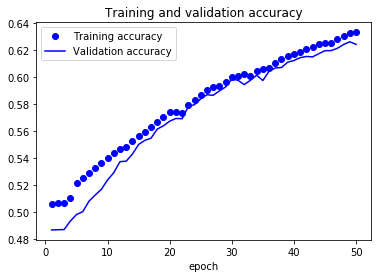

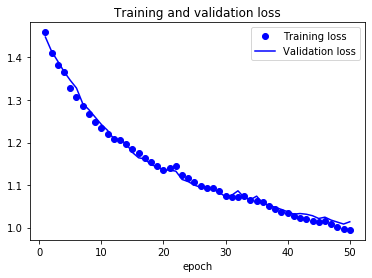

In [107]:
# Plot history
plot_training_history(history)
plot_training_history_loss(history)

## Examine Results

In [20]:
val_mask = np.load(dataset_dir + "/wall_masks/val_label_h.npy")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


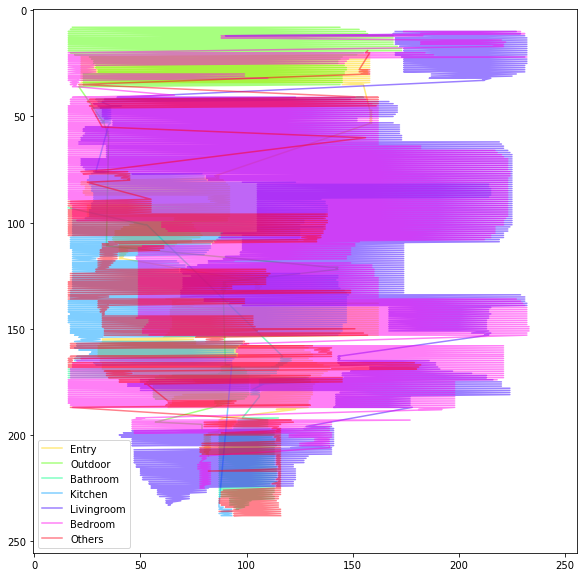

In [93]:
# Try out (blank still T-T)
idx = 1
trial = val_X[idx]
result = model.predict(np.expand_dims(trial, axis=0))[0]
FloorplanSVG.show_map(np.argmax(result, axis=-1), 255*np.ones_like(trial), class2color, class2room)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


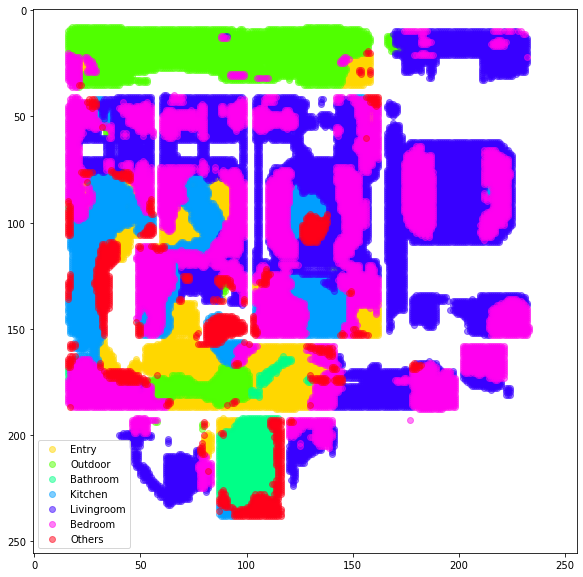

In [102]:
# Try out (blank still T-T)
idx = 1
trial = val_X[idx]
result = model.predict(np.expand_dims(trial, axis=0))[0]
FloorplanSVG.show_map(np.argmax(result, axis=-1), 255*np.ones_like(trial), class2color, class2room)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


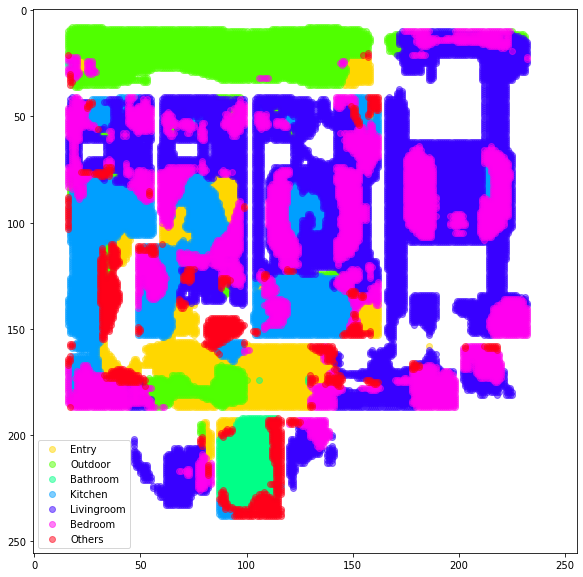

In [109]:
# Try out (blank still T-T)
idx = 1
trial = val_X[idx]
result = model.predict(np.expand_dims(trial, axis=0))[0]
FloorplanSVG.show_map(np.argmax(result, axis=-1), 255*np.ones_like(trial), class2color, class2room)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


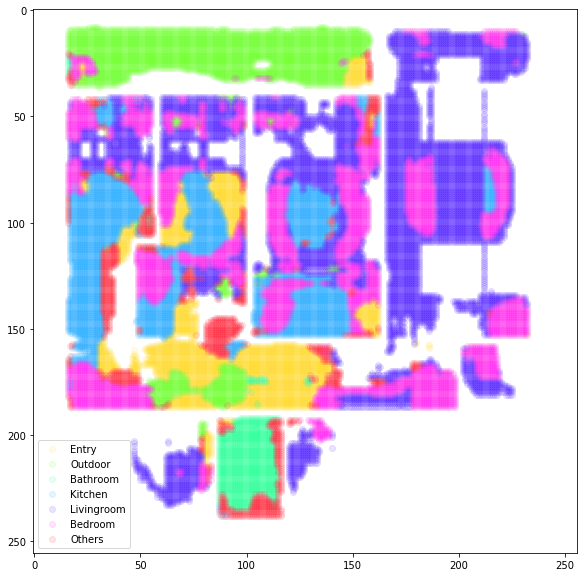

In [117]:
# Try out (blank still T-T)
idx = 1
trial = val_X[idx]
result = model.predict(np.expand_dims(trial, axis=0))[0]
FloorplanSVG.show_map(np.argmax(result, axis=-1), 255*np.ones_like(trial), class2color, class2room)

In [94]:
# Probabilities at certain pixel
result[120, 120]

array([0.05118821, 0.0417559 , 0.08229604, 0.01021844, 0.1312292 ,
       0.23617733, 0.28198534, 0.16514951], dtype=float32)

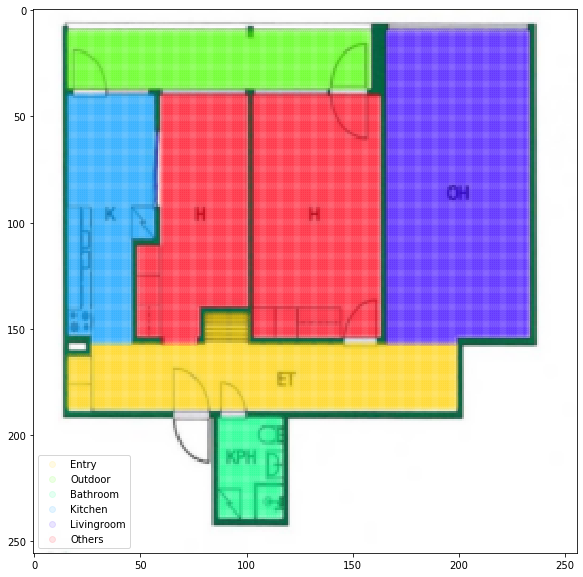

In [116]:
# groundtruth
gt = np.argmax(val_y[idx], axis=-1)
FloorplanSVG.show_map(gt, trial, class2color, class2room)

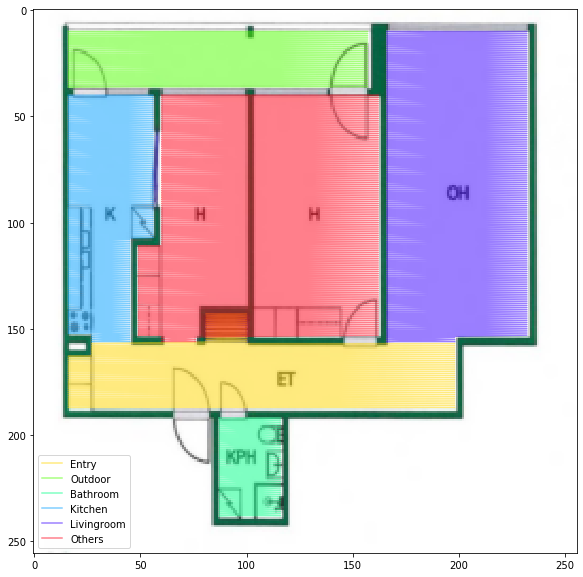

In [95]:
# groundtruth
gt = np.argmax(val_y[idx], axis=-1)
FloorplanSVG.show_map(gt, trial, class2color, class2room)

In [96]:
# Mask result with groundtruth wall mask
def get_result(pred, mask):
    not_empty = mask != 0
    result = pred.copy()
    for x in range(not_empty.shape[0]):
        for y in range(not_empty.shape[1]):
            if not_empty[x, y]:
                result[x, y, 0]= 0
    return result

masked_result = get_result(result, val_mask[idx])

In [97]:
masked_semantic = np.argmax(masked_result, axis=-1)
np.unique(masked_semantic)

array([0, 1, 2, 3, 4, 5, 6, 7])

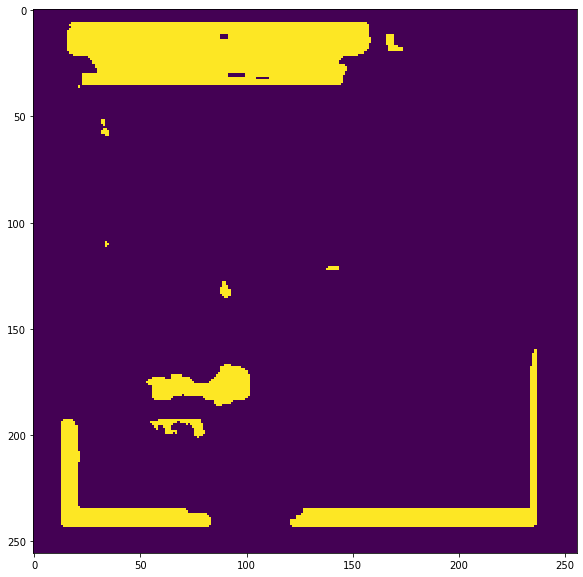

In [98]:
plt.figure(figsize=(10,10))
plt.imshow(masked_semantic == 2)

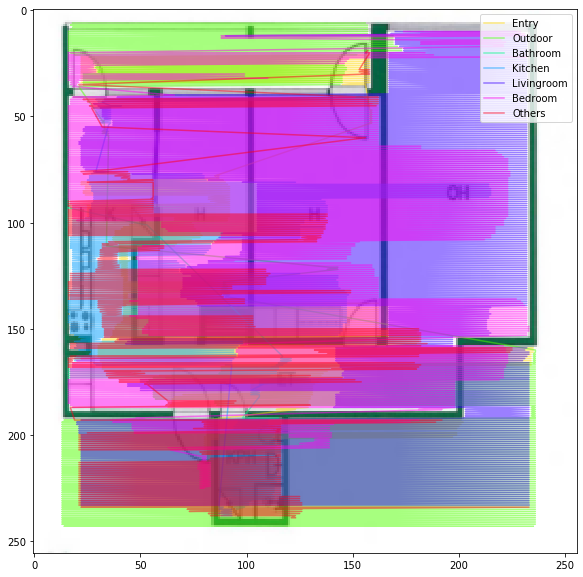

In [99]:
# Show classifications after filering for mask
FloorplanSVG.show_map(np.argmax(masked_result, axis=-1), trial, class2color, class2room)

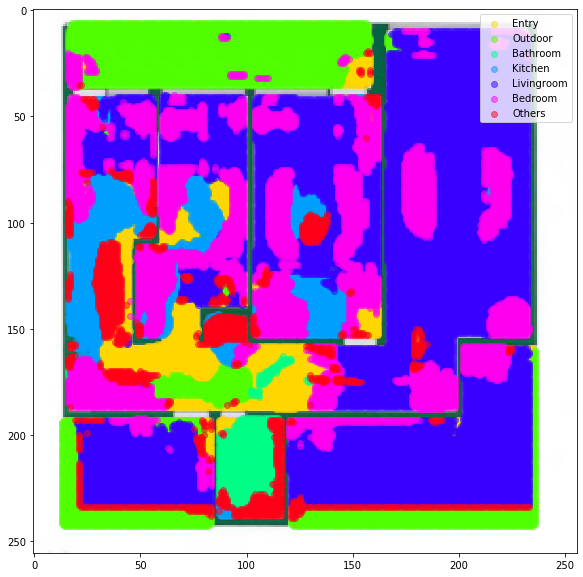

In [103]:
# Show classifications after filering for mask
FloorplanSVG.show_map(np.argmax(masked_result, axis=-1), trial, class2color, class2room)

In [113]:
model.save("room_type_model_3.h5")

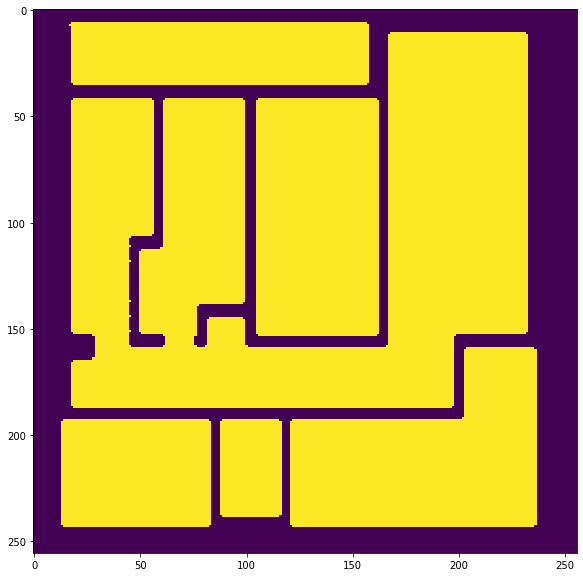

In [76]:
# Show wall mask
plt.figure(figsize=(10,10))
plt.imshow(val_mask[idx] != 0)

In [ ]:
raw = FloorplanRaw(dataset_dir + "/high_quality/7547/")
svg = FloorplanSVG(dataset_dir+"/high_quality/7547/", raw.original_shape, room2class)

In [ ]:
model.predict(np.expand_dims(input_img, axis=0))[0, 200, 100]

In [ ]:
svg = FloorplanSVG(trial_folder, raw.original_shape, room2class)
svg.semantic_map[200, 100]

In [ ]:
# Try model on an example
trial_folder = dataset_dir + "/colorful/3720/"
raw = FloorplanRaw(trial_folder)
input_img = raw.image
result = np.argmax(model.predict(np.expand_dims(input_img, axis=0)), axis=-1)[0]
FloorplanSVG.show_map(result, 255*np.ones_like(input_img), class2color, class2room)

# Groundtruth Display

In [ ]:
# Display a pair of groundtruths
trial_folder = dataset_dir + "/colorful/6327/"
raw = FloorplanRaw(trial_folder)
raw.show()
input_img = raw.image
svg = FloorplanSVG(trial_folder, raw.original_shape, room2class)
svg.show(input_img, class2color, class2room)